In [1]:
# use segment clusters in MCSummer16 to check the shape of 
# dphi(cluster, MET)

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [213]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 2018
pdgId = 13
category = 0


data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/v4/v4/normalized/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_Summer16/v4/v4/normalized/'




if category == 0:
    if data_year == 2016:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
        fpath_bkg['mc'] = mc_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'
#         fpath_bkg['mc'] = mc_path + 'QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

    
    else:
        fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
  
    #     fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'

    lumi = (1.287015729 + 6.941561868 + 3.227904890 + 31.312400879) * 1000

elif category == 1:
    fpath_bkg['mc'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v3/v5/normalized/WH_HToSSTobbbb_ms55_pl10000_1pb_weighted.root'

#     if pdgId == 13:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2.root'
#     else:
#         fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_EGamma_17Sept2018_Run2018D-ZElectron-PromptReco-v2.root'
    lumi = 31.34*1000
else:
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+'/v2/v3/normalized/'
    mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIISummer16/v1/v2/signals/normalized/'
    fpath_bkg['mc'] = mc_path + 'ZH_HToSSTobbbb_ms55_pl1000_1pb_weighted.root'
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_SingleMuon_17Sept2018_Run2018D-ZMu-PromptReco-v2_goodLumi.root'
    lumi = 29.516263349*1000

NEvents = {}

NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print("NEvents_genweight",NEvents_genweight[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_Summer16/v4/v4/normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
NEvents 251816640.0
NEvents_genweight 38944507000000.0
weights [-15.263251  15.263251]
24.595995
190606
0.4377727508544922


# Load trigger

In [214]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# load bdt

In [215]:
# # make predictions for test data

# import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
# y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
# print (y_pred)



In [216]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [221]:
%%time

start_t = time.time()
JET_PT_CUT = 10
MUON_PT_CUT = 20
N_RECHIT_CUT = 12
jetPt_cut = 50
tightid = False
BDT_CUT = 0.26426288 #90% wp
DPHI_CUT = 1
intime = True
weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
genMet = {}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
jetMet_dPhi = {}
jetMet_dPhiMin = {}
jetMet_dPhiMin4 = {}
jetMet_dPhiMin4_50 = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
cscClusterMet_dPhi  = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitClusterSize ={}
cscRechitClusterMaxChamber = {}
cscRechitClusterNChamber = {}
cscRechitClusterNStation = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterMaxChamberRatio = {}
cscRechitClusterZSpread = {}
n_chamber = {}
dphiMet_cluster = {}
bdt_score = {}
gParticlePhi = {}
gParticleEta = {}
gParticleMotherId = {}
gParticlePt = {}
gParticleId = {}
WPt = {}
cscRechitClusterMuonVetoPt = {}
a = {}
b = {}
c = {}
d = {}
legend = {}

legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'

# keys = ['data','mc_intime_bkg','mc_oot_bkg','mc_signal']
keys = ['data_intime','data_oot','mc_signal','mc_bkg']
keys = ['data_intime','mc_signal',]
keys = ['data_intime']
# keys = ['mc_signal']

# keys = ['mc_bkg']
# keys = ['mc_signal','mc_background']
# for k,T in tree_bkg.items():
for k,T in tree_bkg.items():
        
########### SELECTION: CLUSTERS ############
#     sel_rechitcluster = T.array('cscSegClusterMaxStationRatio') > 0.1
    sel_rechitcluster =  np.abs(T.array('cscSegClusterMaxChamber')) > 12
    
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegClusterNSegmentChamberPlus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegClusterNSegmentChamberPlus12') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegClusterNSegmentChamberMinus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegClusterNSegmentChamberMinus12') == 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscSegClusterEta')) < 2.1)


#     sel_rechitcluster =  np.logical_and(sel_rechitcluster, np.abs(T.array('cscSegClusterNStation')) > 0)
#     sel_rechitcluster =  np.logical_and(sel_rechitcluster, np.abs(T.array('cscSegClusterMaxChamberRatio')) > 0.8)
#     sel_rechitcluster =  np.logical_and(sel_rechitcluster, np.abs(T.array('cscSegClusterMaxChamberRatio')) > 0.6)
    
#     sel_rechitcluster =  np.logical_and(sel_rechitcluster, np.abs(T.array('cscSegClusterEta')) < 2.1)

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscSegClusterTime') < 12.5, T.array('cscSegClusterTime') > -5.0))
    n_chamber_temp = (T.array('cscSegClusterNSegmentChamberPlus11') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus11') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus12') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus12') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus13') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus13') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus21') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus21') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus22') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus22') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus31') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus31') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus32') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus32') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus41') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus41') > 0).astype(int) \
        + (T.array('cscSegClusterNSegmentChamberPlus42') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus42') > 0).astype(int) 
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscSegClusterSize') > 15)

    sel_rechitcluster = np.logical_and(sel_rechitcluster, n_chamber_temp<3)
#     sel_1chamber = n_chamber_temp == 1
#     sel_2chamber = np.logical_and(n_chamber_temp == 2, np.abs(T.array('cscSegClusterMaxChamberRatio')-0.5) < 0.2)
#     sel_2chamber = np.logical_or(sel_2chamber, sel_1chamber)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, sel_2chamber)

    if intime:
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscSegClusterJetVetoPt') < JET_PT_CUT)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscSegClusterMuonVetoPt') < MUON_PT_CUT)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscSegClusterTime') < 12.5, T.array('cscSegClusterTime') > -5.0))
    else:
        sel_rechitcluster = np.logical_and(sel_rechitcluster,  T.array('cscSegClusterTime') < -12.5)
    

########### SELECTION: JETS ############
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
    HEM_region = np.logical_and(T.array('jetPhi') <  -0.87, T.array('jetPhi') > -1.57)
    HEM_region = np.logical_and(HEM_region, T.array('jetEta') < -1.3)
    HEM_region = np.logical_and(HEM_region, T.array('jetEta') > -3.0)
    sel_jet_test = np.logical_and(np.abs(T.array('jetPhi') <  2.5), np.abs(T.array('jetPhi') > 1))

#     sel_jet = np.logical_and(sel_jet, np.logical_not(HEM_region))
    if tightid: sel_jet = np.logical_and(sel_jet, T.array('jetPassId'))
    
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
        print("trigger",tr,1.0*np.count_nonzero(hlt[:,tr])/len(hlt[:,tr]))
    sel_ev = np.logical_and(sel_ev, T.array('category') == category)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum() == 1)
    if category == 0:
        sel_ev = np.logical_and(sel_ev,T.array('met') > 200)
        sel_ev = np.logical_and(sel_ev,T.array('nLeptons') == 0)
        sel_ev = np.logical_and(sel_ev, T.array('nJets') >= 1)

        if data_year == 2018:
            sel_ev = np.logical_and(sel_ev, HEM_region.sum() == 0)
#         sel_ev = np.logical_and(sel_ev, T.array('jetMet_dPhiMin4') <= 2)
#         sel_ev = np.logical_and(sel_ev, T.array('cscRechitClusterSize')[sel_rechitcluster].max()<=200)
        if k[:4] == 'data':
            sel_ev = np.logical_and(sel_ev, T.array('Flag_HBHENoiseFilter'))
            sel_ev = np.logical_and(sel_ev, T.array('Flag_HBHEIsoNoiseFilter'))
            sel_ev = np.logical_and(sel_ev, T.array('Flag_BadPFMuonFilter'))
            sel_ev = np.logical_and(sel_ev, T.array('Flag_CSCTightHaloFilter'))
            sel_ev = np.logical_and(sel_ev, T.array('Flag_goodVertices'))
    gLLP_csc[k] = T.array('gLLP_csc')

########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev]
    jetPt[k] = T.array('jetPt')[sel_ev]
    cscRechitClusterPhi[k] = T.array('cscSegClusterPhi')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscSegClusterEta')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterMuonVetoPt[k] = T.array('cscSegClusterMuonVetoPt')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterMaxChamber[k] = T.array('cscSegClusterMaxChamber')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterNChamber[k] = T.array('cscSegClusterNChamber')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscSegClusterNStation')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterMaxStationRatio[k] = T.array('cscSegClusterMaxStationRatio')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterMaxChamberRatio[k] = T.array('cscSegClusterMaxChamberRatio')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterZSpread[k] = T.array('cscSegClusterZSpread')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterSize[k] = T.array('cscSegClusterSize')[sel_rechitcluster][sel_ev][:,0].flatten()

#     n_chamber[k] = (T.array('cscSegClusterNSegmentChamberPlus11') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus11') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus12') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus12') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus13') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus13') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus21') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus21') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus22') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus22') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus31') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus31') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus32') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus32') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus41') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus41') > 0).astype(int) \
#         + (T.array('cscSegClusterNSegmentChamberPlus42') > 0).astype(int) + (T.array('cscSegClusterNSegmentChamberMinus42') > 0).astype(int) 

    
    
    
    
    
#     n_chamber[k] = n_chamber[k][sel_rechitcluster][sel_ev][:,0].flatten()
    genMet[k] = T.array('genMetPtTrue')[sel_ev]

    met[k] = T.array('met')[sel_ev]

    evtNum[k] = T.array('evtNum')[sel_ev]
    lumiSec[k] = T.array('lumiSec')[sel_ev]

    metPhi[k] = T.array('metPhi')[sel_ev]
    nJets[k] = T.array('nJets')[sel_ev]

    jetPhi[k] = T.array('jetPhi')[sel_ev][:,0]

    jetMet_dPhiMin4[k] = T.array('jetMet_dPhiMin4')[sel_ev]
    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]
    jetMet_dPhi[k] = T.array('jetMet_dPhi')[sel_ev]
    cscClusterMet_dPhi[k] = np.abs(T.array('cscSegClusterMet_dPhi')[sel_rechitcluster][sel_ev][:,0].flatten())

    sel_gparticle = np.logical_or(np.abs(T.array('gParticleId')) == 13, np.abs(T.array('gParticleId')) == 11)
    sel_gparticle = np.logical_and(sel_gparticle, T.array('gParticleStatus') == 1)


    sel_tau = np.logical_and(np.abs(T.array('gParticleId')) == 15, np.abs(T.array('gParticleStatus')) == 2)
    sel_gparticle = np.logical_or(sel_tau, sel_gparticle)
    


    sel_gparticle = np.logical_and(sel_gparticle, np.abs(T.array('gParticleMotherId')) == 24)
    sel_w = np.logical_and(np.abs(T.array('gParticleId')) == 24, np.abs(T.array('gParticleStatus')) == 22)


    
    WPt[k] = T.array('gParticlePt')[sel_w][sel_ev]
    gParticlePhi[k] = T.array('gParticlePhi')[sel_gparticle][sel_ev]
    gParticlePt[k] = T.array('gParticlePt')[sel_gparticle][sel_ev]
    gParticleId[k] = T.array('gParticleId')[sel_gparticle][sel_ev]


    gParticleEta[k] = T.array('gParticleEta')[sel_gparticle][sel_ev]
    gParticleMotherId[k] = T.array('gParticleMotherId')[sel_gparticle][sel_ev]



    weight[k] = T.array('weight')[sel_ev]
    npv[k] = T.array('npv')[sel_ev]
    if k[:2] == 'mc':
        pileupWeight[k] = T.array('pileupWeight')[sel_ev]
    else:
        pileupWeight[k] = np.ones(weight[k].shape, dtype=bool)
    if k[:2] == 'mc':
        weight[k] = weight[k]*lumi
    ##### clusters #####
    if not k == 'mc_bkg':
        cscClusterTime[k] = T.array('cscSegClusterTime')[sel_rechitcluster][sel_ev][:,0]
        cscClusterSize[k] =  T.array('cscSegClusterSize')[sel_rechitcluster][sel_ev]
        nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]

    br = 1
    var = jetMet_dPhiMin4[k]
    print("using dPhi(jet,met)")
    DPHI_CUT = 0.25
    a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
    b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
    c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
    d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
    print(a[k],b[k],c[k],d[k])
    print(b[k]/c[k]*d[k],a[k])
    print("uncertainty on a: ", (1./b[k] + 1./c[k] + 1./d[k])**0.5*(b[k]/c[k]*d[k]))
    var = cscClusterMet_dPhi[k]
    DPHI_CUT = 1
    a[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
    b[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT)])
    c[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT)])
    d[k] = br * np.sum(weight[k][np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
    print("using dPhi(cluster,met)")
    print(a[k],b[k],c[k],d[k])
    print(c[k]/b[k]*a[k],d[k])
    print("uncertainty on d: ", (1./c[k] + 1./b[k] + 1./a[k])**0.5*(c[k]/b[k]*a[k]))
    cond = var >= 0.5
    a[k] = br * np.sum(weight[k][np.logical_and(cond, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var>=DPHI_CUT))])
    b[k] = br * np.sum(weight[k][np.logical_and(cond, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var>=DPHI_CUT))])
    c[k] = br * np.sum(weight[k][np.logical_and(cond, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]<N_RECHIT_CUT, var<DPHI_CUT))])
    d[k] = br * np.sum(weight[k][np.logical_and(cond, np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=N_RECHIT_CUT, var<DPHI_CUT))])
    print("using dPhi(cluster,met)")
    print(a[k],b[k],c[k],d[k])
    print(c[k]/b[k]*a[k],d[k])
    print("uncertainty on d: ", (1./c[k] + 1./b[k] + 1./a[k])**0.5*(c[k]/b[k]*a[k]))
    
    
#     if k == 'mc_signal': print(a['mc_signal']/a['data_intime']**0.5)
#     print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k].sum(),len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
#     print(k)



trigger 310 0.9609928333840487
using dPhi(jet,met)
15.263251304626465 0.0 0.0 15.263251304626465
nan 15.263251304626465
uncertainty on a:  nan
using dPhi(cluster,met)
30.52650260925293 15.263251304626465 -15.263251304626465 0.0
-30.52650260925293 0.0
uncertainty on d:  -5.525079421081015
using dPhi(cluster,met)
30.52650260925293 15.263251304626465 15.263251304626465 0.0
30.52650260925293 0.0
uncertainty on d:  12.354453166622335
CPU times: user 7.44 s, sys: 342 ms, total: 7.78 s
Wall time: 7.64 s


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:280: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:281: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:281: RuntimeWarning: invalid value encountered in double_scalars


In [173]:
k = 'mc'
# cscRechitClusterNStation[k]
print(lumiSec[k][cscClusterMet_dPhi[k]<0.5])
print(evtNum[k][cscClusterMet_dPhi[k]<0.5])
# print(cscClusterMet_dPhi[k])
print(np.count_nonzero(cscClusterMet_dPhi[k]<1))
print(cscRechitClusterSize[k][cscClusterMet_dPhi[k]<0.5])

[ 657 9754]
[ 2199843 27178553]
9
[14 13]


# check correlation

In [121]:
k = 'data_intime'
cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= 150
print(k, 'correlation between n_rechits and deltaphi',scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], jetMet_dPhiMin4[k][cond])[0])
print(k, 'correlation between n_rechits and deltaphi',scipy.stats.pearsonr(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], dphiMet_cluster[k][cond])[0])

data_intime correlation between n_rechits and deltaphi -0.27227607836026824
data_intime correlation between n_rechits and deltaphi -0.25030359692824994


In [55]:
k = 'data_intime'
# np.count_nonzero(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>200)
gParticleMotherId['mc']

<JaggedArray [[24] [24] [] ... [-24] [] [24]] at 0x7f5413044ba8>

## Distribution for event level variables in different binnings

80 0.0
50 80 , 0
150 0.0
80 150 , 0
2000 0.0
150 2000 , 0


Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: mc
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: mc
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: mc


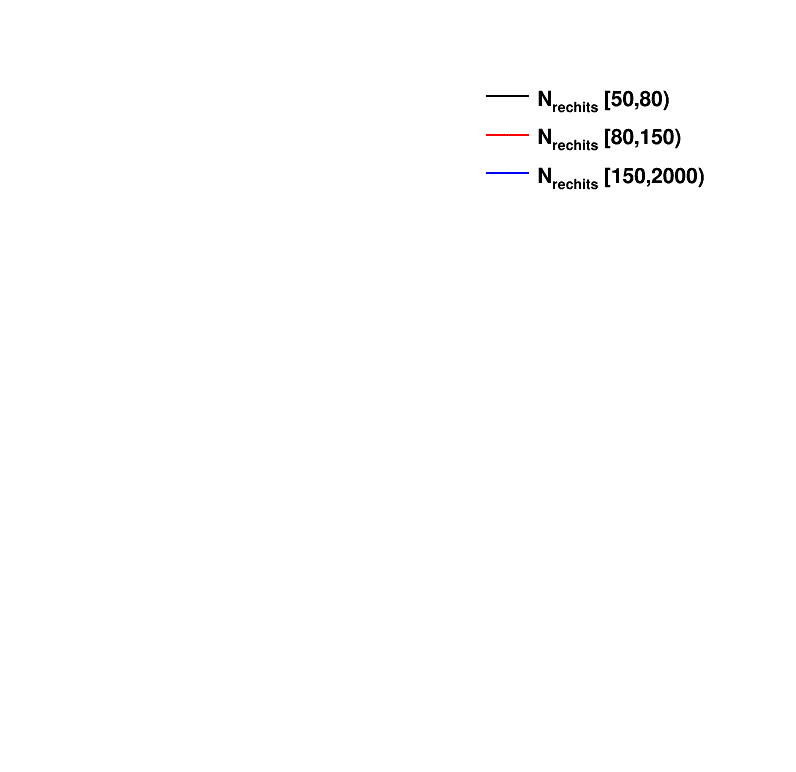

In [116]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.6,0.75,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'mc'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,80,150,2000]
for i,cut in enumerate(cuts):

   
    metcut = 200
    if i == 0:
        previous_cut = cut

        continue
        cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] <= cut
#         cond = angle[k]<=cut
    else:
        cond = np.logical_and(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < cut, nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] >= previous_cut)
#         cond = np.logical_and(angle[k] <= cut, angle[k] > previous_cut)

    print(cut,np.sum(weight[k][cond]))
#     h[k] = create_TH1D( nLeptons[k][cond], axis_title=['N_{lep}', 'Events'], name=k, binning=bins)

#     h[str(i)] = create_TH1D( jetPt[k].count()[cond], axis_title=['N_{jets}', 'Events'], name=k, binning=[15,0,15])
#     h[str(i)] = create_TH1D( jetPt[k][np.logical_and(cond, jetPt[k].count()>0)][:,0], axis_title=['jet p_{T} [GeV]', 'Events'], name=k, binning=[50,0,2500],weights = weight[k][[np.logical_and(cond, jetPt[k].count()>0)]])
    h[str(i)] = create_TH1D( cscRechitClusterPhi[k][cond], axis_title=['csc cluster \phi', 'Events'], name=k, binning=[25,-3.2,3.2])
#     h[str(i)] = create_TH1D( cscRechitClusterEta[k][cond], axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,-3.2,3.2])

#     h[str(i)] = create_TH1D( cscClusterMet_dPhi[k][cond], axis_title=['\Delta \phi(cluster,met)', 'Events'], name=k, binning=[25,0,3.2])
#     h[str(i)] = create_TH1D( metPhi[k][cond], axis_title=['met #phi', 'Events'], name=k, binning=[25,-3.2,3.2])
#     h[str(i)] = create_TH1D( jetPhi[k][cond], axis_title=['leading jet #phi', 'Events'], name=k, binning=[25,-3.2,3.2])
#     h[str(i)] = create_TH1D( jetMet_dPhiMin4[k][cond], axis_title=['min _{4jets}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])

#     h[str(i)] = create_TH1D( jetMet_dPhiMin4[k][cond], axis_title=['min _{4jets}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])
    h[str(i)].SetLineColor(std_color_list[i-1])
    print(previous_cut, cut, "," ,len(jetMet_dPhiMin4[k][cond]))
    leg.AddEntry(h[str(i)], name+" [%(first)d,%(second)d)"%{"first":previous_cut,"second":cut})

#     leg.AddEntry(h[str(i)], "N_{rechits} in (%(first)d,%(second)d]"%{"first":previous_cut,"second":cut})
    previous_cut = cut

#     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
#     h[str(i)].SetMaximum(10E4)
#     h[str(i)].SetMinimum(0.1)



#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[str(i)].GetXaxis().SetLabelSize(0.04)
    h[str(i)].DrawNormalized('same E1')
    

c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

# Roc curve for event level variables

[-13 -13 -15  13  11  15 -13 -15  15  13  13  15 -13 -13 -13 -15  15  13
 -13 -15  13  15 -11 -15  13  13 -15 -13 -13 -13 -13 -15 -15 -13 -13  13
 -13  13  13 -15 -13  13 -13 -13 -13 -13 -15 -15]
[138.17819   273.28156    35.864456  274.40182     5.2738905  84.328064
 281.5627     14.171468  219.87349   229.71573   119.24904   174.26186
   7.688113    6.187711   70.492805   71.438065  188.93547   211.84782
   8.575226    7.4422774 164.88876   158.93384    28.027111  176.3779
  40.860218   80.9307    142.425      13.385061  215.27599    85.65744
 147.2673    144.27328    18.676123  245.5256     75.86332     9.053678
 128.17697   152.445     229.9649     36.180424  210.1011    263.78232
 207.93973    45.837948   93.42576   108.50096   137.24313    24.838577 ]
[ 97.02218    32.695045  333.75958    56.24837   288.94876   145.31906
 122.79304   226.90245   248.11076    21.670437  103.52222   168.0965
 280.77908   366.9091    230.20299   239.29944   246.2184      4.0975637
 167.61835   214.5

Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).


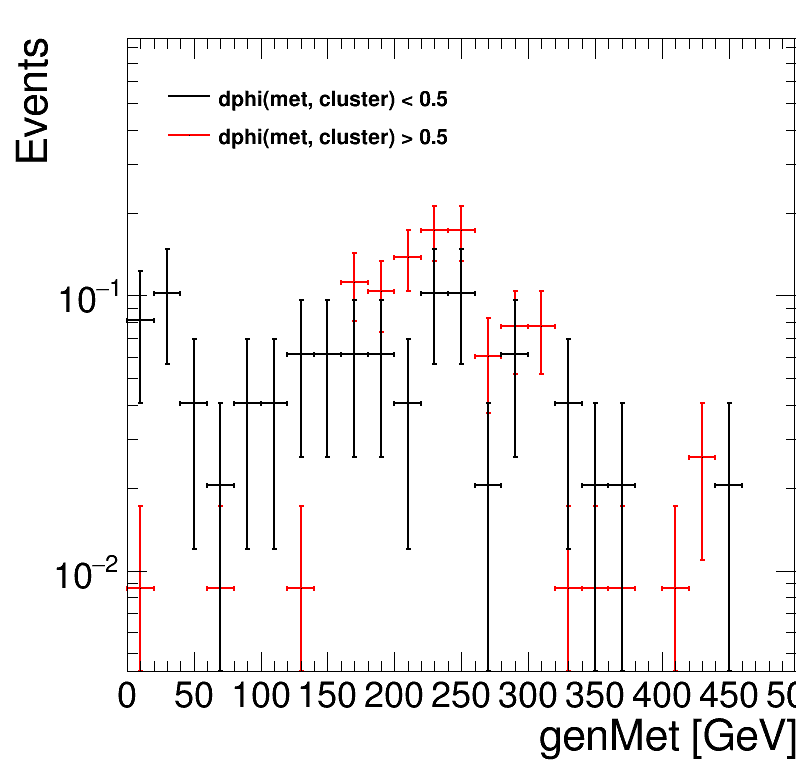

In [71]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.80,0.50,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'mc'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,80,150,2000]
cond = gParticleEta[k].count() == 1
# cond = WPt[k].count() == 1


# h = create_TH1D( np.abs(gParticleEta[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)])[:,0], axis_title=['lepton #eta', 'Events'], name=k, binning=[25,0,2.5])
# h2 = create_TH1D( gParticlePhi[k][np.logical_and(cond, cscClusterMet_dPhi[k]>0.5)], axis_title=['lepton #eta', 'Events'], name=k, binning=[25,0,2.5])

# h = create_TH1D( np.abs(gParticlePt[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)])[:,0], axis_title=['lepton Pt [GeV]', 'Events'], name=k, binning=[25,0,250])
# h2 = create_TH1D( gParticlePt[k][np.logical_and(cond, cscClusterMet_dPhi[k]>0.5)], axis_title=['lepton Pt [GeV]', 'Events'], name=k, binning=[25,0,250])

h = create_TH1D( np.abs(WPt[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)]), axis_title=['W pT[GeV]', 'Events'], name=k, binning=[25,0,500])
h2 = create_TH1D( WPt[k][ np.logical_and(cond,cscClusterMet_dPhi[k]>0.5)], axis_title=['W pT [GeV]', 'Events'], name=k, binning=[25,0,500])

h = create_TH1D( np.abs(genMet[k][ cscClusterMet_dPhi[k]<0.5]), axis_title=['genMet[GeV]', 'Events'], name=k, binning=[25,0,500])
h2 = create_TH1D( genMet[k][ cscClusterMet_dPhi[k]>0.5], axis_title=['genMet [GeV]', 'Events'], name=k, binning=[25,0,500])


# h2 = create_TH1D( met[k][cscClusterMet_dPhi[k]>0.5], axis_title=['lepton Pt [GeV]', 'Events'], name=k, binning=[25,200,500])



print(gParticleId[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)][:,0])

print(gParticlePt[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)][:,0])
print(genMet[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)])


print(np.count_nonzero(np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)))

# print(cscRechitClusterMuonVetoPt[k][np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)][:,0])


cond = np.logical_and(cond, cscClusterMet_dPhi[k]<0.5)

# h2 = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,0,500])
# h2 = create_TH1D( np.abs(cscClusterMet_dPhi[k]), axis_title=['#Delta#phi (MET, cluster)', 'Events'], name=k, binning=[25,0,3.2])


leg.AddEntry(h,"dphi(met, cluster) < 0.5")
leg.AddEntry(h2,"dphi(met, cluster) > 0.5")
h.SetMaximum(100)
h2.SetMaximum(100)



h.SetLineColor(std_color_list[0])
h2.SetLineColor(std_color_list[1])

h2.DrawNormalized('same E1')
h.DrawNormalized('same E1')


c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

In [72]:
np.arange(3.0,7.0,0.1)

array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
       4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5,
       5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8,
       6.9])

# 2D plot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).


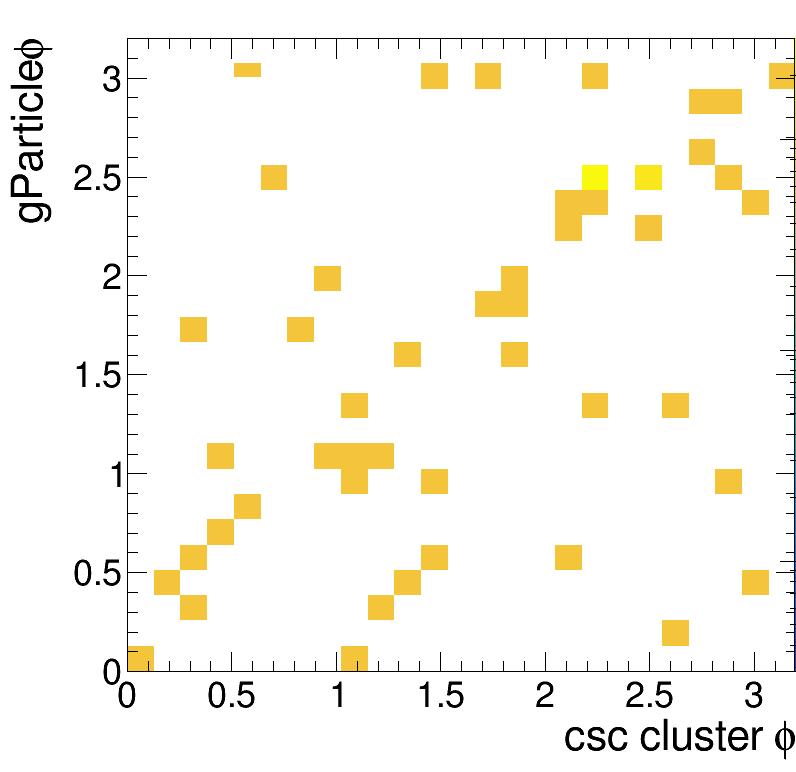

In [56]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.80,0.50,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()



h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'mc'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,80,150,2000]
h = create_TH2D( np.column_stack((cscRechitClusterPhi[k][gParticlePhi[k].count()>0],gParticlePhi[k][gParticlePhi[k].count()>0][:,0])), axis_title=['csc cluster #phi', 'gParticle#phi', 'Events'], name=k, binning=[25,0,3.2,25,0,3.2])

h = create_TH2D( np.column_stack((,gParticlePhi[k][gParticlePhi[k].count()>0][:,0])), axis_title=['csc cluster #phi', 'gParticle#phi', 'Events'], name=k, binning=[25,0,3.2,25,0,3.2])


# h.DrawNormalized('same E1')
h.Draw('colz')


c.SetRightMargin(0)
c.SetLogz()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

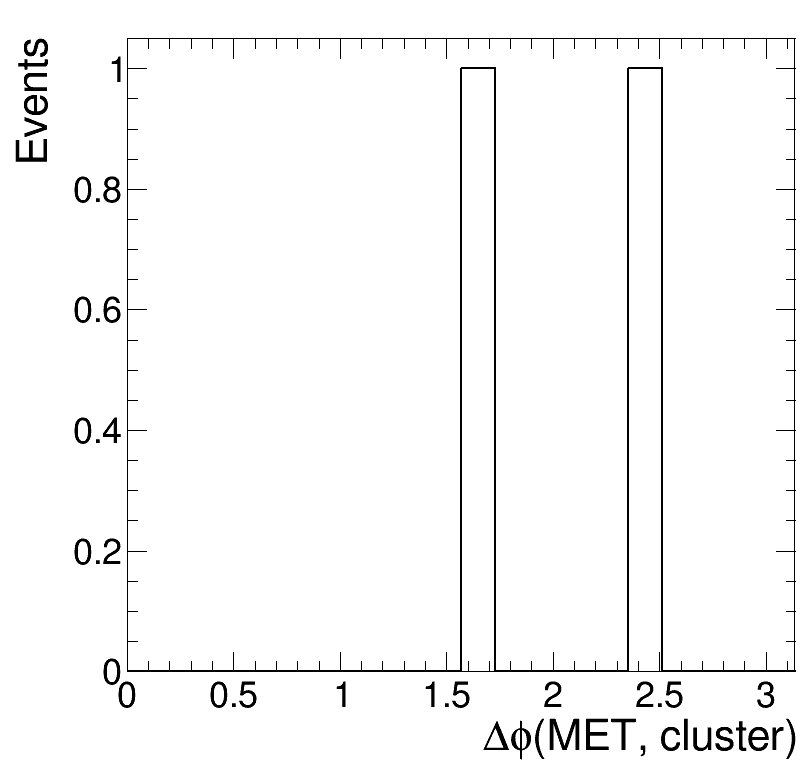

In [192]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()


k = 'mc'

h = {}
rt.gStyle.SetOptFit(1011)

bins = [40,0,1000]
metcut = 200

# cscRechitClusterMaxChamber = {}
# cscRechitClusterNChamber = {}
# cscRechitClusterNStation = {}
# cscRechitClusterMaxStationRatio = {}
# cscRechitClusterMaxChamberRatio = {}

# h[k] = create_TH1D( cscRechitClusterMaxChamber[k], axis_title=['max chamber', 'Events'], name=k, binning=[200,-50,50])
# h[k] = create_TH1D( cscRechitClusterMaxChamberRatio[k], axis_title=['max chamber ratio', 'Events'], name=k, binning=[20,0,1])
h[k] = create_TH1D( cscClusterMet_dPhi[k], axis_title=['#Delta#phi(MET, cluster)', 'Events'], name=k, binning=[20,0,3.14])
# h[k] = create_TH1D( n_chamber[k], axis_title=['Number of Chambers', 'Events'], name=k, binning=[10,0,10])
# print(n_chamber[k])
# h[k] = create_TH1D( cscRechitClusterMaxStationRatio[k], axis_title=['max station ratio', 'Events'], name=k, binning=[20,0,1])
# print(cscRechitClusterMaxStationRatio[k])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['Number of station', 'Events'], name=k, binning=[20,0,10])


# h['1jet'].GetXaxis().SetLabelSize(0.04)
# h['1jet'].SetMinimum(0.1)
# h['1jet'].SetMaximum(10E6/2)

h[k].Draw('hist')


c.SetRightMargin(0)
# c.SetLogy()

c.Draw()
# print(time.time()-start_t)

## significance

0.07687854766845703


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


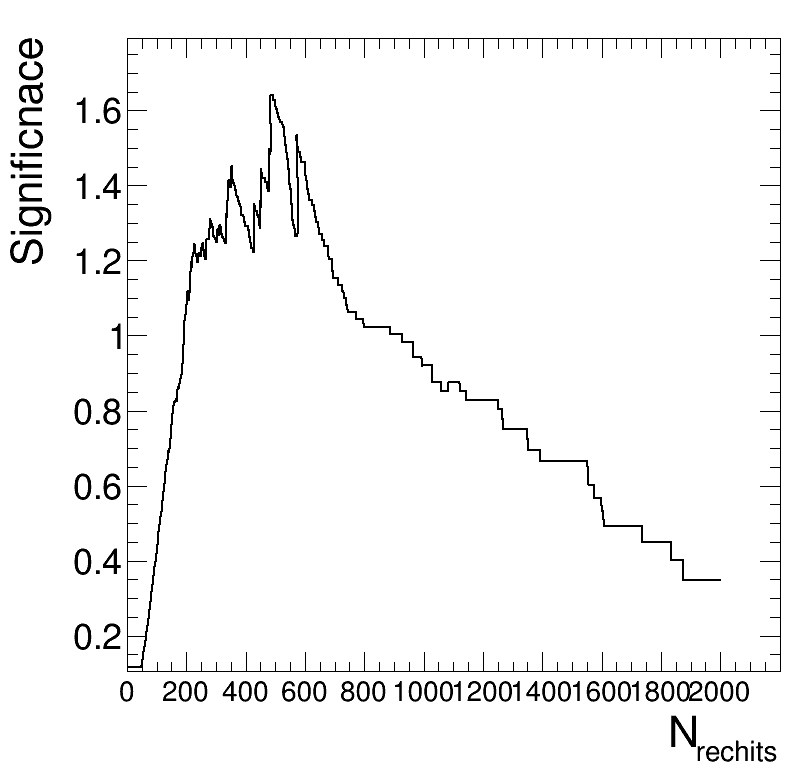

In [37]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'data_oot'
sig_k = 'mc_signal'
br = 0.01

threshold = list(range(300))
threshold = np.array(list(range(2000)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in ['data_oot','mc_signal']:
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['N_{rechits}', 'Significnace'])
#     h[sig_k+str(i)] = create_TGraph(ncsc, event_count[sig_k],  axis_title=['N_{rechits}', 'Event Yield'])

    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 3000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# 2d plot

0.006544828414916992


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


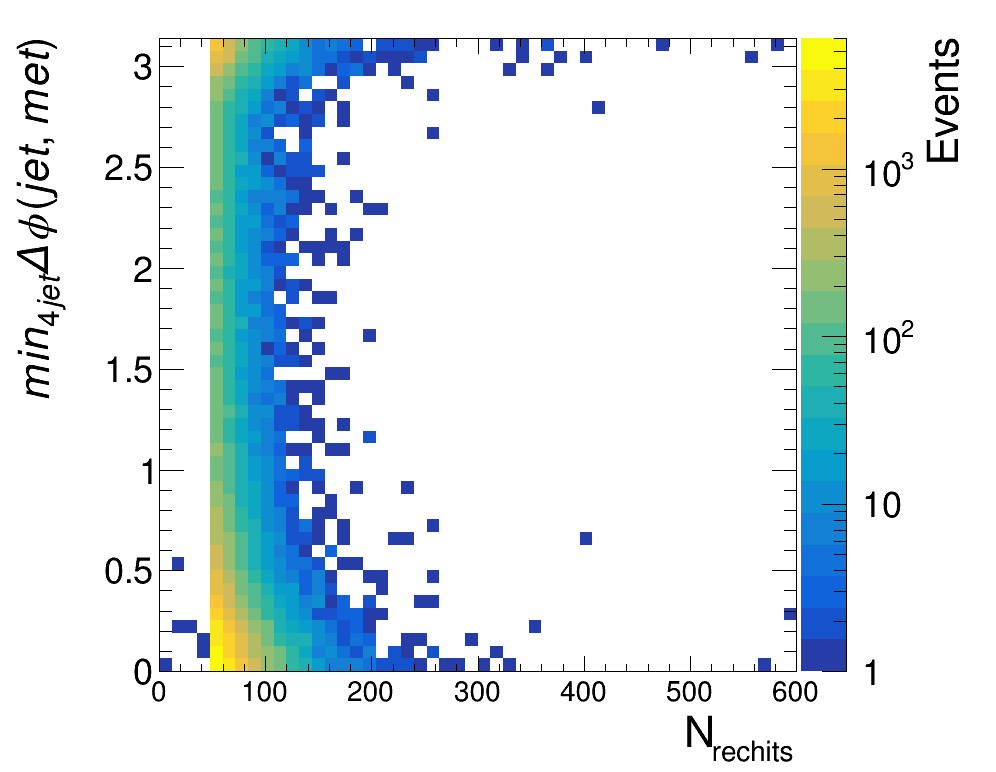

In [125]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin4[k])),
                   axis_title = ['N_{rechits}','min_{4jet}\Delta\phi (jet,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# third

# ROC Curve

# 4th

# nCsc histogram

# event yield vs. ncsc

# significance